                                              Machine Learning project 2018-2019 
                                       Fully-connected neural network to recognize digit

In [1]:
import os # processing file path
import gzip # unzip the .gz file, not used here
import numpy as np # linear algebra
import matplotlib.pyplot as plt # data visualization

from sklearn.model_selection import train_test_split # split train in validation

Function that load the Mnist database and return the pixel of the images and the labels

In [2]:
def load_mnist(path, kind):
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)

    lbpath = gzip.open(labels_path, 'rb')
    labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)

    imgpath = gzip.open(images_path, 'rb')
    images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
# Load the data
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train = load_mnist('.\input', kind='train')
X_test, y_test = load_mnist('.\input', kind='t10k')
m_train = X_train.shape[0]
m_test = X_test.shape[0]

Print the shape of the train and test to know more about the data

In [4]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


Show images from the train set to understand better the task

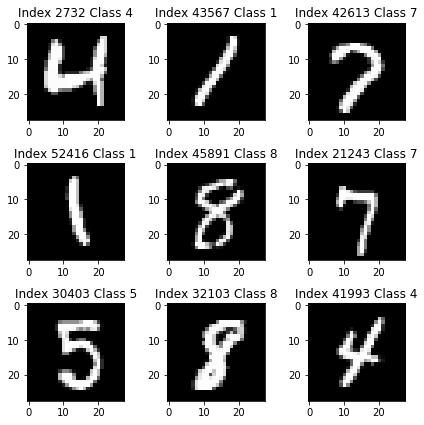

In [5]:
plt.rcParams['figure.figsize'] = [6.0, 6.0]
np.random.seed(0);
indices = list(np.random.randint(m_train,size=9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

Zero-centered the data

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2)

X_train = X_train - np.mean(X_train, axis = 0)
X_test = X_test - np.mean(X_test, axis = 0)
X_val = X_val - np.mean(X_val, axis = 0)

print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(Y_train.shape))
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(Y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (54000, 784)
y_train shape: (54000,)
X_val shape: (6000, 784)
y_val shape: (6000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


This class implements the two layers neural network: 
            1) initialize the weight with small random numbers and the bias with a matrix of zeros.
            2) the Train function runs over a mini-batch of size batch-size (1000) and try to train the model to find the best value of weight and bias using stochastic gradient descent to update and backpropagation to compute the gradients of the functions.
            3) the Loss function is called from the Train function to compute the cross-entropy loss with L2 regularization and to compute the gradients.
            4)the Predict function compute the score of each image in the dataset with the current values of weight and bias and then take the max.
            5) Relu and softmax function compute the score of the images for each labels

In [7]:
class TwoLayerNet():    
    
    def __init__(self, input_size, hidden_size, output_size, std=1e-4): 
        self.W1=  std*np.random.randn(input_size, hidden_size)  
        self.b1= np.zeros((1, hidden_size))     
        self.W2=  std*np.random.randn(hidden_size, output_size)  
        self.b2= np.zeros((1, output_size))

    def loss(self, X, y, reg):
        W1, b1 = self.W1, self.b1  # 784x10, 1x10
        W2, b2 = self.W2, self.b2  # 10x10, 1x10
        N, D = X.shape # 1000, 784
        
        # Compute the forward pass
        h1 = ReLU(np.dot(X, W1) + b1) #(N,10)
        scores = np.dot(h1, W2) + b2 #(N,10)

        probs = softmax(scores)  #(N,10)  
        
         # Compute the loss
        correct_logprobs = -np.log(probs[range(N), y])        #(N,) cross-entropy loss       
        data_loss = np.sum(correct_logprobs) / N       
        reg_loss =  1/2*reg*(np.sum(W1*W1) + np.sum(W2*W2))  # L2 regularization
        loss = data_loss + reg_loss
        
        # Backward pass: compute gradients
        
        # backpropagation with chain role for softmax
        dscores = probs                                 
        dscores[range(N), y] -= 1                       
        dscores /= N  

        # backpropagation with chain role for scores
        dW2 = np.dot(h1.T, dscores)                # (H,C)
        db2 = np.sum(dscores, axis=0, keepdims=True)    # (1,C)
        dh1 = np.dot(dscores, W2.T)                     # (N,H)
        
        dh1[h1 <= 0] = 0   #relu
        
        # backpropagation with chain role for h1
        dW1 = np.dot(X.T, dh1)                      # (D,H)
        db1 = np.sum(dh1, axis=0, keepdims=True)        # (1,H)
        
        dW2 += (reg/N) * W2
        dW1 += (reg/N) * W1
        
        return loss, dW1, db1, dW2, db2 

    def train(self, X, y, X_val, y_val, learning_rate, reg, num_epochs, batch_size, verbose=False):   
        
        num_train = X.shape[0]
        iterations_per_epoch = max(int(num_train / batch_size), 1) # 54000/1000 = 54
        
        # Use SGD to optimize the parameters 
        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for it in range(1, num_epochs * iterations_per_epoch + 1):   # one epoch is 54 iterations of different minibatch
            # Create a random minibatch of training data and labels
            sample_index = np.random.choice(num_train, batch_size, replace=True)   
            X_batch = X[sample_index, :]    # 1000x784      
            y_batch = y[sample_index]   # 1000     
            
            # Compute loss and gradients using the current minibatch
            loss, dW1, db1, dW2, db2 = self.loss(X_batch, y=y_batch, reg=reg) 
            loss_history.append(loss)
                     
            # Use the gradients to update the parameters of the network             
            self.W2 += - learning_rate * dW2 
            self.b2 += - learning_rate * db2
            self.W1 += - learning_rate * dW1
            self.b1 += - learning_rate * db1
            
            if verbose and it % iterations_per_epoch == 0:    
            # Every epoch, check train and val accuracy and decay learning rate. 
                epoch = it / iterations_per_epoch
                train_acc, val_acc = self.info(X_batch, y_batch, X_val, y_val)
                train_acc_history.append(train_acc)    
                val_acc_history.append(val_acc) 
                print("epoch %d / %d: loss %f, train_acc: %f, val_acc: %f" %(epoch, num_epochs, loss, train_acc, val_acc))
                 
                learning_rate *= 1/np.sqrt(epoch) # update the step in the gradient descent 
                
                
        return loss_history, train_acc_history, val_acc_history

    def predict(self, X):       
        h1 = ReLU(np.dot(X, self.W1) + self.b1)    
        scores = np.dot(h1, self.W2) + self.b2   
        y_pred = np.argmax(scores, axis=1)    
        return y_pred

    def info(self, X_batch, y_batch, X_val, y_val):   
        train_acc = (self.predict(X_batch) == y_batch).mean()    
        val_acc = (self.predict(X_val) == y_val).mean()        
        return train_acc, val_acc
    
def ReLU(x):        
    return np.maximum(0, x)

def softmax(scores):
    scores_max = np.max(scores, axis=1, keepdims=True)    # (N,1)
    exp_scores = np.exp(scores - scores_max)              # (N,10) trick for numerical stability
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # (N,10)
    return probs

Run all a first time with a fixed learning rate and regularization strength to see if the model we built is doing a pretty good job

In [8]:
input_size = X_train.shape[1] #784
hidden_size = 10
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
loss_history, train_acc_history, val_acc_history = net.train(X_train, Y_train, X_val, Y_val,
            num_epochs=10, batch_size=1000,
            learning_rate=1e-3,
            reg=0.25, verbose=True)

epoch 1 / 10: loss 2.225601, train_acc: 0.305000, val_acc: 0.308000
epoch 2 / 10: loss 1.086690, train_acc: 0.578000, val_acc: 0.563000
epoch 3 / 10: loss 0.861453, train_acc: 0.695000, val_acc: 0.707167
epoch 4 / 10: loss 0.683239, train_acc: 0.799000, val_acc: 0.789667
epoch 5 / 10: loss 0.627492, train_acc: 0.801000, val_acc: 0.808833
epoch 6 / 10: loss 0.619915, train_acc: 0.826000, val_acc: 0.820333
epoch 7 / 10: loss 0.604876, train_acc: 0.821000, val_acc: 0.822500
epoch 8 / 10: loss 0.553280, train_acc: 0.838000, val_acc: 0.823667
epoch 9 / 10: loss 0.561810, train_acc: 0.839000, val_acc: 0.824167
epoch 10 / 10: loss 0.630385, train_acc: 0.817000, val_acc: 0.824333


Plot the loss function (cross-entropy function with L2 regularization) and the train/ validation accuracies to visualize what is going on and to understand if we are overfitting

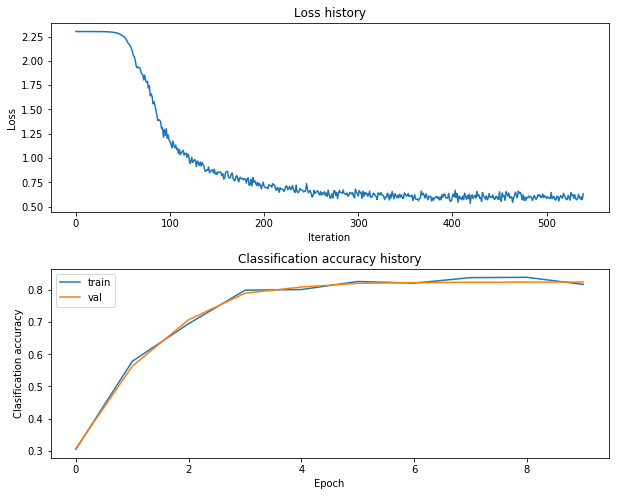

In [9]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.subplots_adjust(wspace =0, hspace =0.3)


# Plot the loss function and train / validation accuracies

plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history , label='train')
plt.plot(val_acc_history, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

Here we try different values of learning rates and regularization strengths on train and validation dataset to find the best values in order to reach the highest accuracy 

In [10]:
hidden_size = 10
num_classes = 10

results = {}
best_val = -1
best_net = None

learning_rates = np.array([2.5,5,7.5,10])*1e-3
regularization_strengths = [0.25,0.5,0.75,1]   

for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        loss_history, train_acc_history, val_acc_history = net.train(X_train, Y_train, X_val, Y_val,
        num_epochs=10, batch_size=1000,
        learning_rate=lr,
        reg= reg, verbose=False)
        val_acc = (net.predict(X_val) == Y_val).mean()
        if val_acc > best_val:
            best_val = val_acc
            best_net = net         
        results[(lr,reg)] = val_acc


for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (
                lr, reg,  val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.500000e-03 reg 2.500000e-01 val accuracy: 0.914500
lr 2.500000e-03 reg 5.000000e-01 val accuracy: 0.919667
lr 2.500000e-03 reg 7.500000e-01 val accuracy: 0.924500
lr 2.500000e-03 reg 1.000000e+00 val accuracy: 0.923333
lr 5.000000e-03 reg 2.500000e-01 val accuracy: 0.926000
lr 5.000000e-03 reg 5.000000e-01 val accuracy: 0.928833
lr 5.000000e-03 reg 7.500000e-01 val accuracy: 0.925833
lr 5.000000e-03 reg 1.000000e+00 val accuracy: 0.925833
lr 7.500000e-03 reg 2.500000e-01 val accuracy: 0.928333
lr 7.500000e-03 reg 5.000000e-01 val accuracy: 0.927000
lr 7.500000e-03 reg 7.500000e-01 val accuracy: 0.924500
lr 7.500000e-03 reg 1.000000e+00 val accuracy: 0.926667
lr 1.000000e-02 reg 2.500000e-01 val accuracy: 0.925333
lr 1.000000e-02 reg 5.000000e-01 val accuracy: 0.927667
lr 1.000000e-02 reg 7.500000e-01 val accuracy: 0.922500
lr 1.000000e-02 reg 1.000000e+00 val accuracy: 0.924833
best validation accuracy achieved during cross-validation: 0.928833


In [11]:
y_pred = best_net.predict(X_test)
test_acc = (y_pred == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.9348


In [12]:
def confusion_matrix_builder(y_test, y_pred):
    confusion_matrix = np.zeros((10,10), dtype=int)
    for i in range(len(y_test)):

        if(y_pred[i] == y_test[i]):
            confusion_matrix[y_pred[i]][y_pred[i]] += 1
        elif(y_pred[i] != y_test[i]):
            confusion_matrix[y_test[i]][y_pred[i]] += 1
            
    return confusion_matrix            


Print the confusion matrix in order to understand what the model recognized better and what worst.
The rows of the matrix represent the true label of the images and the columns represent the label that the model predicted.
In this way the diagonal of the matrix represent the number of digits that we predicted good.

In [13]:
myConfusion_matrix = confusion_matrix_builder(y_test, y_pred)
print(myConfusion_matrix)

[[ 958    0    3    0    1    4    9    2    3    0]
 [   0 1113    3    2    1    2    1    1   12    0]
 [   8   11  951   10    8    2   10    9   20    3]
 [   2    3   31  921    0   19    1    8   14   11]
 [   1    0    4    0  913    1   11    1    2   49]
 [  10    5    5   13    7  806   11    3   29    3]
 [   9    2    8    1    6    8  922    0    2    0]
 [   1    7   25    9    3    0    1  950    0   32]
 [   5   10   12   18   12   16    8    4  875   14]
 [   6    5    1   12   25    7    0   11    3  939]]


Just print 3 number we fail when predicting to undersand better how bad or good our model is, compared with human recognition

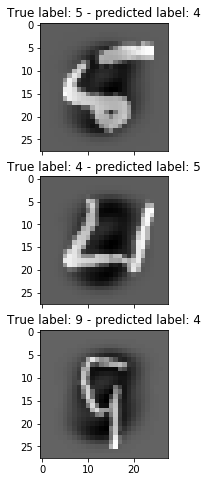

In [14]:
errors = (y_pred - y_test != 0)

Y_pred_errors = y_pred[errors]
Y_true_errors = y_test[errors]
X_true_errors = X_test[errors]


def display_errors(Y_pred_errors, Y_true_errors, X_true_errors):
    r = 0
    fig, ax = plt.subplots(3,sharex=True,sharey=True)
    for i in range(3):
        ax[r].imshow(X_true_errors[i].reshape(28,28))
        ax[r].set_title("True label: {} - predicted label: {}".format(Y_true_errors[i], Y_pred_errors[i]))
        r +=1

display_errors(Y_pred_errors, Y_true_errors, X_true_errors)